In [2]:
from itertools import permutations
import pandas as pd
import numpy as np
import qutip
import matplotlib.pyplot as plt
import seaborn
import time
%matplotlib inline

In [3]:
initialstate=[1,0,1,0,1,0,1,0]
b=list(permutations(initialstate))
b=list(set(b))

def listtostr(l):
    s=''
    for i in l:
        s=s+str(i)
    return s

def strlist(b):
    index = []
    for li in b:
        index.append(listtostr(li))
    return index

def find_rel_sta(a):
    rel_sta=[]
    tm=len(a)-1
    a=[int(x) for x in a]
    for i in range(len(a)-1):
        if a[i]!=a[i+1]:
            sta = a[:]
            tm = tm-2
            sta[i],sta[i+1]=sta[i+1],sta[i]
            rel_sta.append(sta)
    return rel_sta,tm

index = strlist(b)
dim = len(index)
initialstateindex = index.index(listtostr(initialstate))

In [4]:
s=pd.DataFrame(np.zeros((dim,dim)),index=index,columns=index)

In [5]:
for i in range(dim):
    s[index[i]][strlist(find_rel_sta(index[i])[0])]=0.5
    s.iloc[i][i]=0.25*find_rel_sta(index[i])[1]

In [6]:
Hamiltonian=4*qutip.Qobj(s.as_matrix())
eigsta=Hamiltonian.eigenstates()[1]
eigen=Hamiltonian.eigenstates()[0]
print Hamiltonian

Quantum object: dims = [[70], [70]], shape = (70, 70), type = oper, isherm = True
Qobj data =
[[-3.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0. -1. ...,  0.  2.  0.]
 ..., 
 [ 0.  0.  0. ..., -1.  0.  0.]
 [ 0.  0.  2. ...,  0. -5.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


In [7]:
# Antiferromagnetic State
AFRho = qutip.basis(dim,index.index('10101010'))
# Phase Separated State
PSRho = qutip.basis(dim,index.index('00001111'))
# Random States
tmp = np.random.rand(dim,1)
tmp = (tmp/np.sum(tmp))**0.5
RandRho = qutip.Qobj(tmp)
# Mixed states
MixRho = (qutip.ket2dm(AFRho)+qutip.ket2dm(PSRho))/2.0

States={'AFRho':AFRho,'PSRho':PSRho,'RandRho':RandRho,'MixRho':MixRho}
Keys=['AFRho','PSRho','RandRho','MixRho']

In [609]:
t=qutip.mesolve(Hamiltonian,qutip.ket2dm(qutip.basis(70,45)),[0,1],[])

In [594]:
# plt.axis([0,12,0,0.1])
# plt.plot(t.times,t.expect[0])
# plt.plot(t.times,t.expect[1])
# plt.plot(t.times,t.expect[2])
# print t.times
# print t.states

In [8]:
def generHa(index):
    disoHa=np.zeros((dim,dim))
    b = np.random.normal(0,1,len(initialstate))
    for i in range(dim):
        a=np.array(list(index[i]),dtype='int16')
        disoHa[i][i]=np.sum(-b*((-1)**a))
    return disoHa

In [9]:
def run(t,eta,inistate):
    tmps=qutip.mesolve(Hamiltonian+generHa(index),inistate,[0,t],[])
    for i in range(eta-1):
        tmps=qutip.mesolve(Hamiltonian+generHa(index),tmps.states[1],[0,t],[])
    return [qutip.expect(qutip.ket2dm(qutip.basis(dim,i)),tmps.states[1]) for i in range(dim)]

def genPurierror(test,initialstate,NU=500):
    if qutip.isket(initialstate):
        pur = (qutip.ket2dm(initialstate)*qutip.ket2dm(initialstate)).tr()
    elif qutip.isoper(initialstate):
        pur = (initialstate*initialstate).tr()
    else:
        print 'Wrong State form'
    test=np.array(test)
    average1 = np.sum(test,axis=0)/NU 
    average2 = np.sum(test*test,axis=0)/NU
    return np.average(average2*dim*(dim+1)-(average1*dim)**2-pur)

def gen_vag_er(t,eta,times,inistate,NU=500):
    error=[]
    for j in range(times):
        test=[]
        for i in range(NU):
            Pe=run(t,eta,inistate)
            test.append(Pe)
        error.append(genPurierror(test,inistate,NU))
    return np.average(np.abs(error))

In [10]:
Ereta2={}
for state in Keys:
    Ereta2[state]={}
Ereta2

{'AFRho': {}, 'MixRho': {}, 'PSRho': {}, 'RandRho': {}}

In [11]:
start=time.clock()
start0=start

for state in Keys[:3]:
    print state
    for eta in [1,4,10,20,40]:
        Ereta2[state][str(eta)]=gen_vag_er(1,eta,10,States[state],NU=500)
        print str(eta)+': ',Ereta2[state][str(eta)]
        print time.clock()-start,'s'
        start=time.clock()
    print '_'*50
    
print 'Total time: ',time.clock()-start0,'s'

AFRho
1:  1.35224781335
195.398057 s
4:  0.309751746734
265.91997 s
10:  0.0284502507612
407.270619 s
20:  0.00617138901779
634.095891 s
40:  0.01091791021
1091.355598 s
__________________________________________________
PSRho
1:  6.05848363965
188.822433 s
4:  1.63540909159
254.893647 s
10:  0.0921213518994
391.686528 s
20:  0.00796678561452
621.378377 s
40:  0.0088117659822
1082.696619 s
__________________________________________________
RandRho
1:  1.09666817303
191.15034 s
4:  0.383441971765
258.977335 s
10:  0.0108018705127
396.233448 s
20:  0.007274077502
622.371321 s
40:  0.00777072591418
1081.053482 s
__________________________________________________
Total time:  7683.307376 s


In [12]:
start=time.clock()
start0=start

for state in Keys[3:]:
    print state
    for eta in [1,4,10,20,40]:
        Ereta2[state][str(eta)]=gen_vag_er(1,eta,1,States[state],NU=500)
        print str(eta)+': ',Ereta2[state][str(eta)]
        print time.clock()-start,'s'
        start=time.clock()
    print '_'*50
    
print 'Total time: ',time.clock()-start0,'s'
print Ereta2

MixRho
1:  1.8273812236
173.278245 s
4:  0.422447012113
578.551447 s
10:  0.0336087226228
1436.066862 s
20:  0.00428237688702
2836.18121 s
40:  0.00446319008549
5641.346701 s
__________________________________________________
Total time:  10665.430782 s
{'PSRho': {'1': 6.0584836396461714, '10': 0.092121351899429021, '20': 0.0079667856145226677, '4': 1.6354090915932484, '40': 0.0088117659821985803}, 'MixRho': {'1': 1.8273812235980484, '10': 0.033608722622777178, '20': 0.0042823768870182801, '4': 0.42244701211291752, '40': 0.0044631900854864189}, 'RandRho': {'1': 1.0966681730276124, '10': 0.01080187051270688, '20': 0.0072740775019960024, '4': 0.38344197176476708, '40': 0.0077707259141835518}, 'AFRho': {'1': 1.3522478133532632, '10': 0.028450250761197969, '20': 0.0061713890177917613, '4': 0.30975174673426747, '40': 0.01091791020996489}}


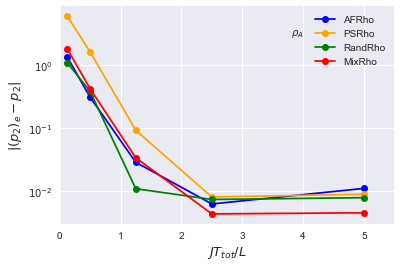

In [20]:
timeli = np.sort(np.array(Ereta2[Keys[0]].keys(),dtype='int'))
plt.plot(timeli/8.0,[Ereta2[Keys[0]][str(i)] for i in timeli],'bo-')
timeli = np.sort(np.array(Ereta2[Keys[1]].keys(),dtype='int'))
plt.plot(timeli/8.0,[Ereta2[Keys[1]][str(i)] for i in timeli],'o-',color='orange')
timeli = np.sort(np.array(Ereta2[Keys[2]].keys(),dtype='int'))
plt.plot(timeli/8.0,[Ereta2[Keys[2]][str(i)] for i in timeli],'go-')
timeli = np.sort(np.array(Ereta2[Keys[3]].keys(),dtype='int'))
plt.plot(timeli/8.0,[Ereta2[Keys[3]][str(i)] for i in timeli],'ro-')
plt.yscale('log')
plt.xlabel(r'$JT_{tot}/L$',fontsize=13)
plt.ylabel(r'$|(p_2)_e-p_2|$',fontsize=13)
plt.text(3.8,3,r'$\rho_A$')
plt.xlim(0,5.5)
#plt.ylim(0.001,12)
plt.legend(Keys[:4])
plt.savefig('differentstates.pdf',format='pdf',orientation='portrait',papertype='executive')

{'PSRho': {'10': 0.89839848646174347, '12': 0.80790366998860164, '20': 0.40765704426667487, '16': 0.56850684255459683, '30': 0.15458357652150859, '40': 0.18395416251348309, '2': 0.99999999999991862, '4': 0.99999314168581321, '6': 0.99554645375854511}, 'RandRho': {'10': 0.18153435184647332, '12': 0.17611310731850441, '20': 0.13982200472300144, '16': 0.10252203198471684, '30': 0.092933522857161416, '40': 0.086424178394710546, '2': 0.37245616723775277, '4': 0.54291264150918528, '6': 0.39180597235357073}, 'AFRho': {'10': 0.58256964467273886, '12': 0.41878661623780983, '20': 0.086185470966228153, '16': 0.14216583060044721, '30': 0.13642586178539173, '40': 0.11868689853975778, '2': 1.93721953724762, '4': 2.1067963277983175, '6': 1.2729965978047519}}


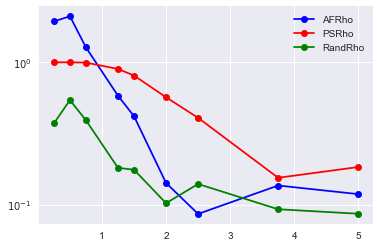

In [710]:
timeli = np.sort(np.array(Ereta[Keys[0]].keys(),dtype='int'))
plt.plot(timeli/8.0,[Ereta[Keys[0]][str(i)] for i in timeli],'bo-')
timeli = np.sort(np.array(Ereta[Keys[1]].keys(),dtype='int'))
plt.plot(timeli/8.0,[Ereta[Keys[1]][str(i)] for i in timeli],'ro-')
timeli = np.sort(np.array(Ereta[Keys[2]].keys(),dtype='int'))
plt.plot(timeli/8.0,[Ereta[Keys[2]][str(i)] for i in timeli],'go-')
plt.yscale('log')
plt.legend(Keys[:3])
print Ereta

In [475]:
start=time.clock()
start0=start

for i in np.linspace(7.5,9,2):
    quenchtime[str(i)]=gen_vag_er(i,30,10,NU=500)
    print str(i)+': ',quenchtime[str(i)]
    print time.clock()-start,'s'
    start=time.clock()
    
print 'Total time: ',time.clock()-start0,'s'

7.5:  0.105355470234
1207.411181 s
9.0:  0.0760588547072
1338.352706 s
Total time:  2545.764606 s


In [479]:
start=time.clock()
start0=start

for i in np.linspace(9.5,10.5,2):
    quenchtime[str(i)]=gen_vag_er(i,30,10,NU=500)
    print str(i)+': ',quenchtime[str(i)]
    print time.clock()-start,'s'
    start=time.clock()
    
print 'Total time: ',time.clock()-start0,'s'

9.5:  0.0902619575842
1394.950583 s
10.5:  0.0686615708557
1476.057478 s
Total time:  2871.008529 s


In [492]:
totaltimes={}

In [493]:
start=time.clock()
start0=start

for i in np.array(np.linspace(5,50,10),dtype='int'):
    totaltimes[str(i)]=gen_vag_er(2,i,10,NU=500)
    print str(i)+': ',totaltimes[str(i)]
    print time.clock()-start,'s'
    start=time.clock()
    
print 'Total time: ',time.clock()-start0,'s'

5:  2.09806604632
140.555155 s
10:  0.704869739996
254.837883 s
15:  0.271150754263
373.873381 s
20:  0.149028301794
488.72595 s
25:  0.123062983389
602.208824 s
30:  0.10771693612
714.697281 s
35:  0.0968962269413
826.374881 s
40:  0.0662278014518
940.652077 s
45:  0.0961452594443
1053.866166 s
50:  0.0964785817344
1169.000328 s
Total time:  6564.793927 s


In [17]:
df=pd.DataFrame(Ereta2)
df.to_csv('differentstates.csv')
df.sort_values(by=['PSRho','MixRho'])

,AFRho,MixRho,PSRho,RandRho
20,0.006171,0.004282,0.007967,0.007274
40,0.010918,0.004463,0.008812,0.007771
10,0.028450,0.033609,0.092121,0.010802
4,0.309752,0.422447,1.635409,0.383442
1,1.352248,1.827381,6.058484,1.096668


In [18]:
Ereta2

{'AFRho': {'1': 1.3522478133532632,
  '10': 0.028450250761197969,
  '20': 0.0061713890177917613,
  '4': 0.30975174673426747,
  '40': 0.01091791020996489},
 'MixRho': {'1': 1.8273812235980484,
  '10': 0.033608722622777178,
  '20': 0.0042823768870182801,
  '4': 0.42244701211291752,
  '40': 0.0044631900854864189},
 'PSRho': {'1': 6.0584836396461714,
  '10': 0.092121351899429021,
  '20': 0.0079667856145226677,
  '4': 1.6354090915932484,
  '40': 0.0088117659821985803},
 'RandRho': {'1': 1.0966681730276124,
  '10': 0.01080187051270688,
  '20': 0.0072740775019960024,
  '4': 0.38344197176476708,
  '40': 0.0077707259141835518}}